In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
cf3  = np.genfromtxt('cf3.csv' , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_cf3 = cf3['PGC']
DM_cf3  = cf3['DM']
eDM_cf3 = cf3['eDM']
N_cf3   = cf3['N']  
C_cf3   = cf3['C']  
F_cf3   = cf3['F']
I_cf3   = cf3['I']
S_cf3   = cf3['S']
H_cf3   = cf3['H']
VVmod_cf3 = cf3['Vmod']
Ks_cf3 = cf3['Ks']

In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        table
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [126]:
table = np.genfromtxt('DMs_EDD.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

pgc_edd = table['pgc']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
inc   = table['inc']
Vmod_edd   = table['Vmod']
Vls_edd   = table['Vls']

DM_edd  = table['DMr']
dDM_edd = table['dDMr']


DM_edd  = table['DMi']
dDM_edd = table['dDMi']


# DM_edd  = table['DMz'] 
# dDM_edd = table['dDMz']

# dDM_edd = table['dDMz']
# DM_edd  = (table['DMr']+table['DMi']+table['DMz'])/3.


# DM_edd  = table['DM_w1']
# dDM_edd = table['dDM_w1']




ggg = table['ggg']
rrr = table['rrr']
iii = table['iii']
zzz = table['zzz']
w11 = table['w1']
w22 = table['w2']


Sqlt = table['Sqlt']
Wqlt = table['Wqlt']



I = iii-DM_edd
W1 = w11-DM_edd
print len(pgc_edd)

g_i = ggg-iii

10736


In [127]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']


In [128]:
logD = (DM_edd-25)/5.
logH = np.log10(Vmod_edd) - logD  

keep = pgc_edd*0.

p = 0
for i, idd in enumerate(pgc_edd):
    
    if not idd in pgc_drop:
        
        keep[i] = 1
    else:
        p+=1

        
print p

473


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [129]:
indx, = np.where((logH<10) & (logH>0.5) & (Vmod_edd>4000) & (iii>0) & (I<-17) & (zzz>0)  & (rrr>0)
                 & (Sqlt>=2) & (keep==1) & (logWimx>0.) & (iii<100) & (DM_edd>0))

# indx, = np.where((logH<2.5) & (logH>1.5) & (Vmod_edd>4000) & (w11>0) & (Wqlt>3) & 
#                  (keep==1) & (W1<-16.1))

Vmod = Vmod_edd[indx]
X0 = logWimx[indx]
X1  = logWimx_e[indx]
Ye = 0.2*dDM_edd[indx]
V  = Vls_edd[indx]
Y  = logH[indx]
lgD = logD[indx]
I = I[indx]
ID = pgc_edd[indx]
DM = DM_edd[indx]
INC = inc[indx]
mag_i = iii[indx]
mag_z = zzz[indx]
GI = g_i[indx]
W1 = W1[indx]
w1_mag = w11[indx]
P = X0/X1

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


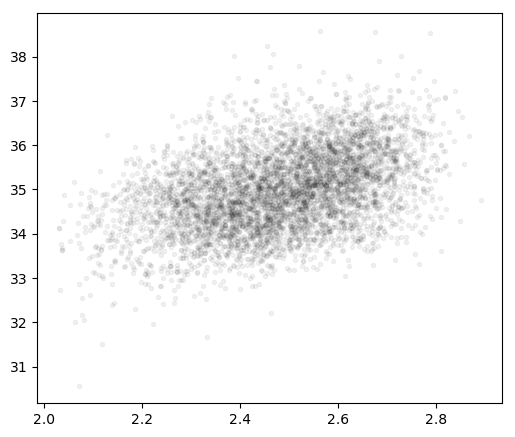

In [130]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(X0, DM, 'k.', alpha=0.05)



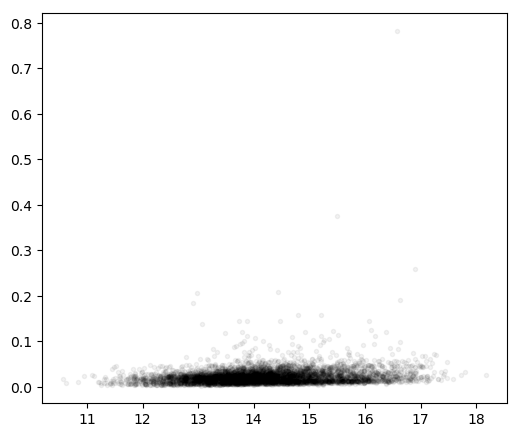

In [131]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(mag_i, X1, 'k.', alpha=0.05)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35ef583710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35f1dc1190>)

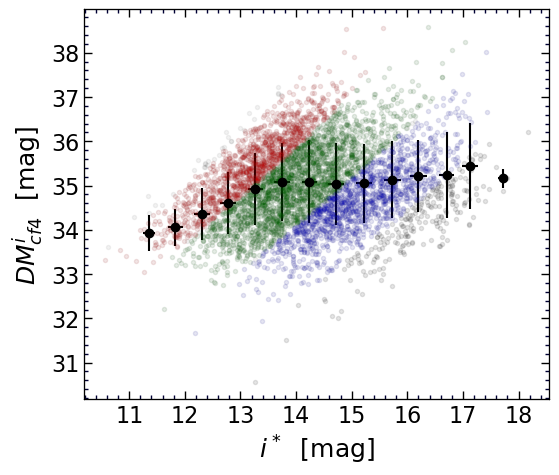

In [132]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(mag_i, DM, 'k.', alpha=0.05)

# plt.ylim(2,3)

for i in range(len(mag_i)):
    
    if X0[i]>0.0 and X0[i]<2.2:
        ax.plot(mag_i[i], DM[i], 'k.', alpha=0.05)
    if X0[i]>2.2 and X0[i]<2.4:
        ax.plot(mag_i[i], DM[i], 'b.', alpha=0.05)
    if X0[i]>2.4 and X0[i]<2.6:
        ax.plot(mag_i[i], DM[i], 'g.', alpha=0.05)
    if X0[i]>2.6 and X0[i]<2.8:
        ax.plot(mag_i[i], DM[i], 'r.', alpha=0.05)

for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(DM)):
        xi = mag_i[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(DM[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='black', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.set_ylabel(r'$DM^i_{cf4}$' + '  [mag]', fontsize=18) 
ax.set_xlabel(r'$i^*$'+ '  [mag]', fontsize=18) 

set_axes(ax)

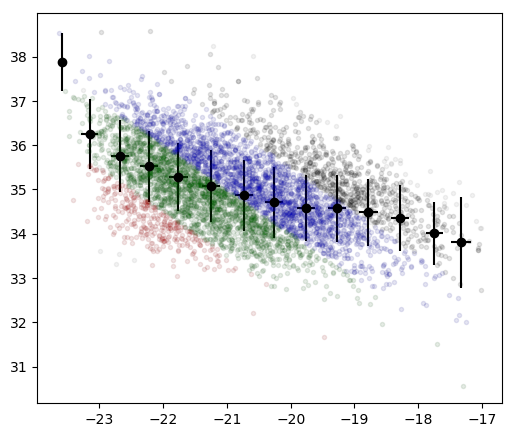

In [133]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(I, DM, 'k.', alpha=0.05)

# plt.ylim(2,3)

# for i in range(len(mag_i)):
    
#     if X0[i]>0.0 and X0[i]<2.2:
#         ax.plot(I[i], DM[i], 'k.', alpha=0.0|5)
#     if X0[i]>2.2 and X0[i]<2.4:
#         ax.plot(I[i], DM[i], 'b.', alpha=0.05)
#     if X0[i]>2.4 and X0[i]<2.6:
#         ax.plot(I[i], DM[i], 'g.', alpha=0.05)
#     if X0[i]>2.6 and X0[i]<2.8:
#         ax.plot(I[i], DM[i], 'r.', alpha=0.05)

for i in range(len(mag_i)):
    
    if mag_i[i]>11 and mag_i[i]<12.5:
        ax.plot(I[i], DM[i], 'r.', alpha=0.05)
    if mag_i[i]>12.5 and mag_i[i]<14:
        ax.plot(I[i], DM[i], 'g.', alpha=0.05)
    if mag_i[i]>14 and mag_i[i]<15.5:
        ax.plot(I[i], DM[i], 'b.', alpha=0.05)
    if mag_i[i]>15.5 and mag_i[i]<17:
        ax.plot(I[i], DM[i], 'k.', alpha=0.05)


for i in np.arange(-24,-17,0.5):
    xp = []
    yp = []
    for ii in range(len(DM)):
        xi = I[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(DM[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='black', ms=6)     
#         print np.median(xp), 10**np.median(yp)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f35da0e3b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35e7aabc90>)

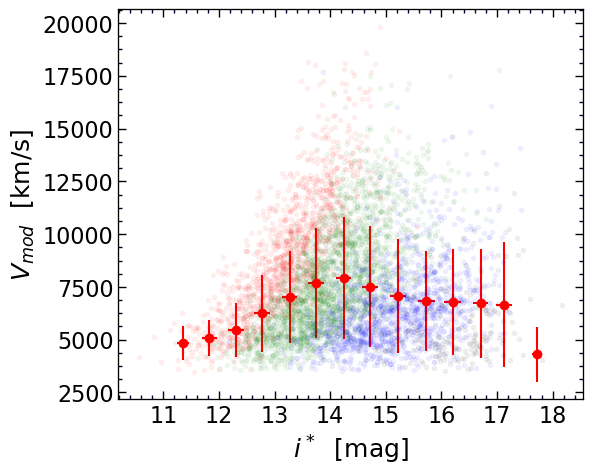

In [134]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# plt.plot(mag_i, V, 'k.', alpha=0.05)
for i in range(len(mag_i)):
    
    if X0[i]>2.0 and X0[i]<2.2:
        ax.plot(mag_i[i], V[i], 'k.', alpha=0.05)
    if X0[i]>2.2 and X0[i]<2.4:
        ax.plot(mag_i[i], V[i], 'b.', alpha=0.05)
    if X0[i]>2.4 and X0[i]<2.6:
        ax.plot(mag_i[i], V[i], 'g.', alpha=0.05)
    if X0[i]>2.6 and X0[i]<2.8:
        ax.plot(mag_i[i], V[i], 'r.', alpha=0.05)


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(mag_i)):
        xi = mag_i[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(V[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.set_ylabel(r'$V_{mod}$' + '  [km/s]', fontsize=18) 
ax.set_xlabel(r'$i^*$'+ '  [mag]', fontsize=18) 

set_axes(ax)

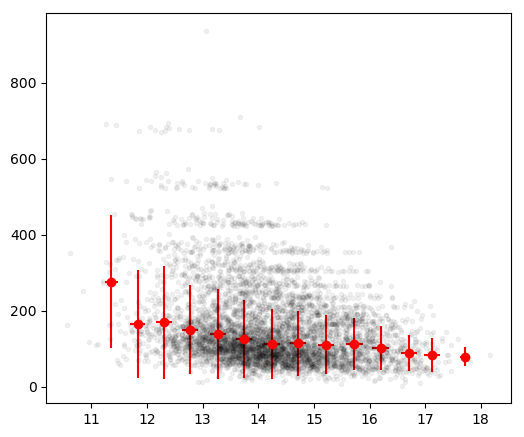

In [135]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(mag_i, P, 'k.', alpha=0.05)

# plt.ylim(2,3)


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(mag_i)):
        xi = mag_i[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(P[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     


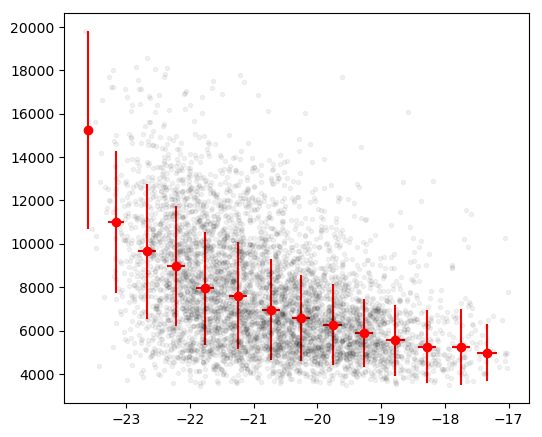

In [136]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(I, V, 'k.', alpha=0.05)

# plt.ylim(2,3)


for i in np.arange(-24,-17,0.5):
    xp = []
    yp = []
    for ii in range(len(I)):
        xi = I[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(V[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

(array([  12.,  124.,  453., 1073., 1369., 1063.,  627.,  336.,  101.,
           8.]),
 array([10.57, 11.33, 12.09, 12.85, 13.61, 14.37, 15.13, 15.89, 16.65,
        17.41, 18.17]),
 <a list of 10 Patch objects>)

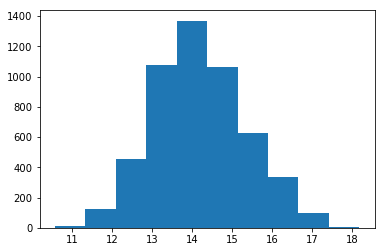

In [137]:
plt.hist(mag_i)

(array([ 74., 487., 925., 984., 876., 773., 580., 291., 125.,  51.]),
 array([-23.64 , -22.977, -22.314, -21.651, -20.988, -20.325, -19.662,
        -18.999, -18.336, -17.673, -17.01 ]),
 <a list of 10 Patch objects>)

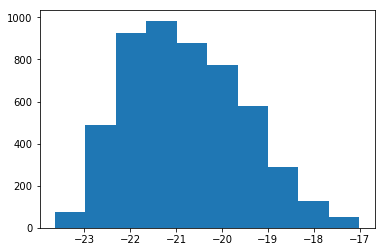

In [138]:
plt.hist(I)

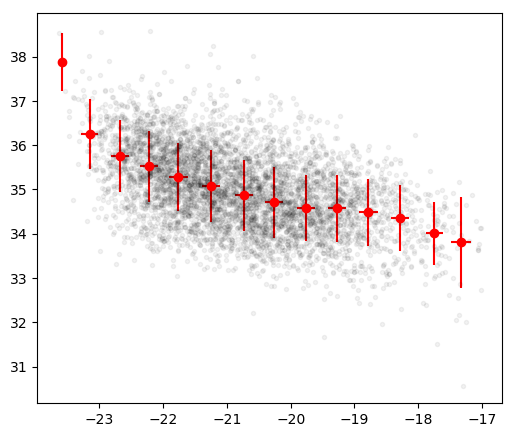

In [139]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(I, DM, 'k.', alpha=0.05)

# plt.ylim(2,3)


for i in np.arange(-24,-17,0.5):
    xp = []
    yp = []
    for ii in range(len(DM)):
        xi = I[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(DM[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

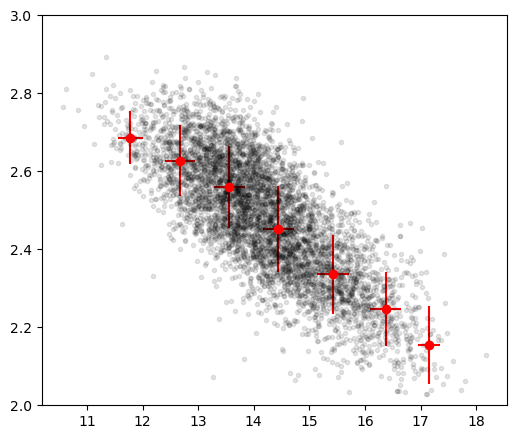

In [140]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(mag_i, X0, 'k.', alpha=0.1)

plt.ylim(2,3)


for i in np.arange(11,18,1):
    xp = []
    yp = []
    for ii in range(len(X0)):
        xi = mag_i[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(X0[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

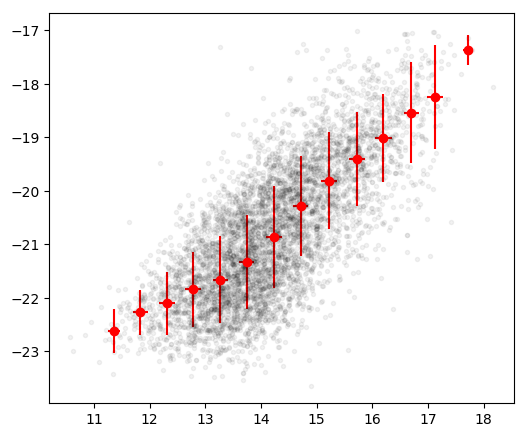

In [141]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(mag_i, I, 'k.', alpha=0.05)


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(mag_i)):
        xi = mag_i[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(I[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

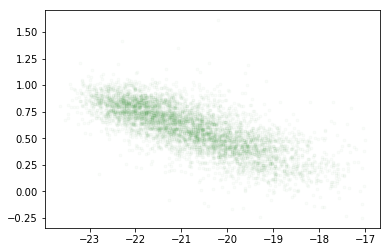

In [142]:
plt.plot(I, GI, 'g.', alpha=0.02)

[-0.01010523  0.2651112   0.13895814]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35d608ead0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35d8f94a10>)

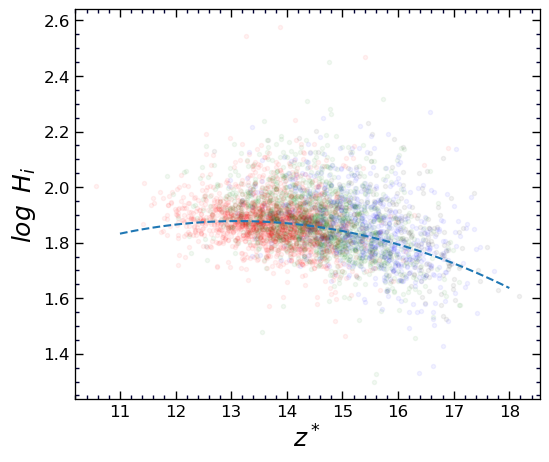

In [143]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


# ax.plot(mag_i,Y, 'k.', alpha=0.1)
for i in range(len(mag_i)):
    
    if GI[i]>0 and GI[i]<0.2:
        ax.plot(mag_i[i], Y[i], 'k.', alpha=0.05)
    if GI[i]>0.2 and GI[i]<0.4:
        ax.plot(mag_i[i], Y[i], 'b.', alpha=0.05)
    if GI[i]>0.4 and GI[i]<0.6:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.05)
    if GI[i]>0.6 and GI[i]<0.8:
        ax.plot(mag_i[i], Y[i], 'r.', alpha=0.05)


        
X = mag_i 

ax.set_xlabel(r'$z^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 

v = np.linspace(11,18,50)

c = np.polyfit(X[X>13.],Y[X>13.], 2, w=1./Ye[X>13.])
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')


print c

set_axes(ax, fontsize=12)



In [ ]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(mag_i,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
        
X = mag_i 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$i^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 

v = np.linspace(11,18,50)


fit, cov = curve_fit(hf, X, Y, sigma=Ye)
ax.plot(v,hf(v, fit[0], fit[1], fit[2]), '--')#, color='cyan')

print c

set_axes(ax, fontsize=12)



y = Y[(mag_i>12) & (mag_i<17)]
ye = Ye[(mag_i>12) & (mag_i<17)]
print 10**np.median(Y)
print  10**(np.sum(y/ye)/np.sum(1./ye))
med = np.sum(y/ye)/np.sum(1./ye)


# print "Fit med:", 10**(hf(fit[0], fit[0], fit[1], fit[2]) )



c = np.polyfit(X[(X>12.5)&(X<14.5)],Y[(X>12.5)&(X<14.5)], 1, w=1./Ye[(X>12.5)&(X<14.5)])
ax.plot(v,c[0]*v+c[1], '--')
Y = Y - (c[0]*X+c[1]) + med


print med, 10**med

ax.set_xlim(11,18)

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(w1_mag,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(w1_mag[i], Y[i], 'g.', alpha=0.1)  
        
        
X = w1_mag 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$W1^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(11,18,50)

c = np.polyfit(X,Y, 2)#, w=1./Ye[(X>2.3)&(X<2.8)])
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')


print c

set_axes(ax, fontsize=12)
# med = np.median(Y[(w1_mag>11) & (w1_mag<15)])

print med, 10**med

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(INC,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)



for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(INC[i], Y[i], 'g.', alpha=0.1)  
        
        


In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(I,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(I[i], Y[i], 'g.', alpha=0.1)   
        
        
X = I 


for i in np.arange(-24,-17,0.7):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.7:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)
        
ax.set_xlabel(r'$M_i$'+' [Mag]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 


v = np.linspace(-24,-18,50)
c = np.polyfit(X[X>-23],Y[X>-23], 2)#, w=1./Ye[(X>2.3)&(X<2.8)])
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')


# med = np.median(Y[(I>-23) & (I<-20)])
# med = np.median(Y[(I>-23) & (I<-20)])
print med, 10**med

# Y = Y - (c[0]*X**2+c[1]*X+c[2])+ med

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(X0,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)
print np.median(Y), 10**np.median(Y)

g = []
for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(X0[i], Y[i], 'g.', alpha=0.1)   
        g.append(Y[i])
print np.median(g), 10**np.median(g)

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(0,0.1)
ax.set_ylim(1.3,2.8)
v = np.linspace(0,0.09,50)

X = X1

xx = X
yy = Y

c = np.polyfit(X[X<0.04],Y[X<0.04], 1, w=1./Ye[X<0.04])


print 'C= ', c

# med = 1.8714665629836822
# med = np.sum(Y[X<0.04]/Ye[X<0.04])/np.sum(1./Ye[X<0.04])

print 'Median = ', med,  10**med

ax.plot(X, Y, 'k.', alpha=0.1)
ax.plot(v,c[0]*v+c[1], '--')


XL = []
YL = []
YLe = []
for i in np.arange(0,0.08,0.01):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.01:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        print np.median(xp), 10**np.median(yp)
        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel('eLogW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{i}$'+'  adjusted', fontsize=18) 



set_axes(ax)

print 10**med

Y = Y - (c[0]*X+c[1]) + med  


In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = X0 

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(2.2,2.8,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel('logW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(2,3,50)
# c = np.polyfit(XL,YL, 1, w=1./np.asarray(YLe))
c = np.polyfit(X[(X>2.2)&(X<2.8)],Y[(X>2.2)&(X<2.8)], 1, w=1./Ye[(X>2.2)&(X<2.8)])
ax.plot(v,c[0]*v+c[1], '--')


print c

set_axes(ax, fontsize=12)


Y = Y - (c[0]*X+c[1])+ med


ax.set_ylim(1,3)

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = V

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls  [km/s]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{w1}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
# c = np.polyfit(XL,YL, 1, w=1./np.asarray(YLe))
c = np.polyfit(X,Y, 1, w=1./Ye)
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print 10**np.median(Y)
print  10**(np.sum(Y/Ye)/np.sum(1./Ye))

In [ ]:
len(Y)

-23.415 55.2779208837977
-22.814999999999998 69.59415808187048
-22.200000000000003 71.33114186007035
-21.550000000000004 72.38643201617106
-20.849999999999998 74.88613107806547
-20.17 74.73037191211908
-19.490000000000002 71.50672056192533
-18.84 72.19677783156473
-18.160000000000004 73.1429263648156
-17.509999999999998 86.11124854370821
1.8615737087346846 72.70657868091979


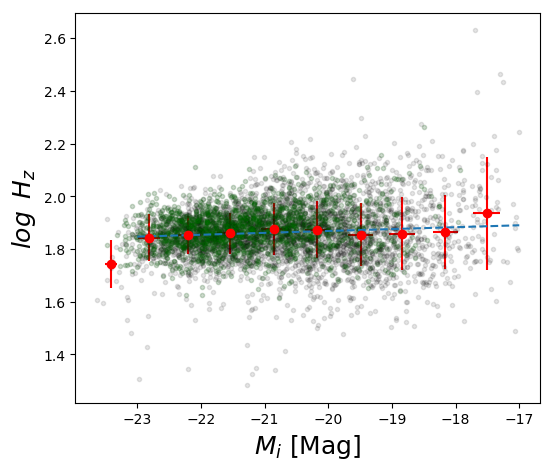

In [117]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(I,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(I[i], Y[i], 'g.', alpha=0.1)   
        
        
X = I 


for i in np.arange(-24,-17,0.7):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.7:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)
        
ax.set_xlabel(r'$M_i$'+' [Mag]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 


v = np.linspace(-23,-17,50)
c = np.polyfit(X[X>-23],Y[X>-23], 1)#, w=1./Ye[(X>2.3)&(X<2.8)])
ax.plot(v,c[0]*v+c[1], '--')


med = np.median(Y[(I>-22) & (I<-21)])
print med, 10**med

# Y = Y - (c[0]*X+c[1])+ med

11.355 85.31429493874973
11.83 80.71748067565231
12.31 76.12409540699741
12.78 76.99842319565684
13.27 75.9098945905264
13.74 74.61048724882828
14.24 73.58189391472338
14.71 71.77999898492348
15.22 68.5115420043729
15.73 63.20626509358624
16.2 58.9272478019455
16.705 55.329164613446444
17.130000000000003 57.81623144903382
17.72 47.25093721314332
[-0.0144214   2.07463936]
1.8503365172587647 70.84945555709919


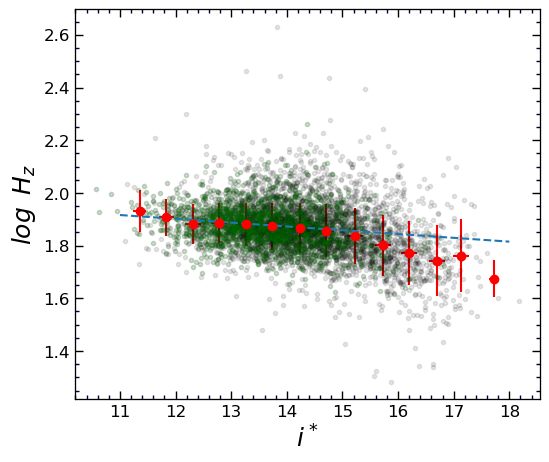

In [124]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(mag_i,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
X = mag_i 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$i^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(11,18,50)

c = np.polyfit(X[(X>12.5)&(X<14.5)],Y[(X>12.5)&(X<14.5)], 1, w=1./Ye[(X>12.5)&(X<14.5)])
ax.plot(v,c[0]*v+c[1], '--')

print c

set_axes(ax, fontsize=12)

med0 = np.median(Y)

print med0, 10**med0

C=  [-0.1226637   1.86249744]
Median =  1.8608541710891402 72.58621839824636
0.008 73.76497893760316
0.014 72.74195048627624
0.024 72.36913397002334
0.033 71.57911338739571
0.044 75.89550371826091
0.054 76.77375308372893
0.062 70.29244484919963
0.073 68.12622190158096


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35e2bde050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35e2cae150>)

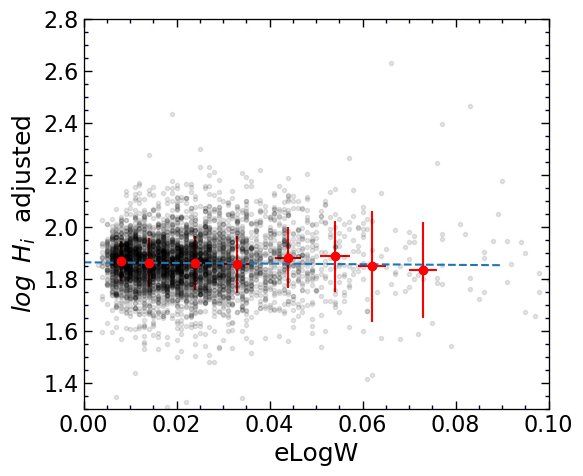

In [120]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(0,0.1)
ax.set_ylim(1.3,2.8)
v = np.linspace(0,0.09,50)

X = X1

xx = X
yy = Y

c = np.polyfit(X[X<0.04],Y[X<0.04], 1, w=1./Ye[X<0.04])


print 'C= ', c

med00 = np.sum(Y[X<0.02]/Ye[X<0.02])/np.sum(1./Ye[X<0.02])

print 'Median = ', med00,  10**med00




ax.plot(X, Y, 'k.', alpha=0.1)
ax.plot(v,c[0]*v+c[1], '--')


XL = []
YL = []
YLe = []
for i in np.arange(0,0.08,0.01):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.01:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        print np.median(xp), 10**np.median(yp)
        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel('eLogW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{i}$'+'  adjusted', fontsize=18) 



set_axes(ax)


Text(0.5,0,'$DM_{cf3}$')

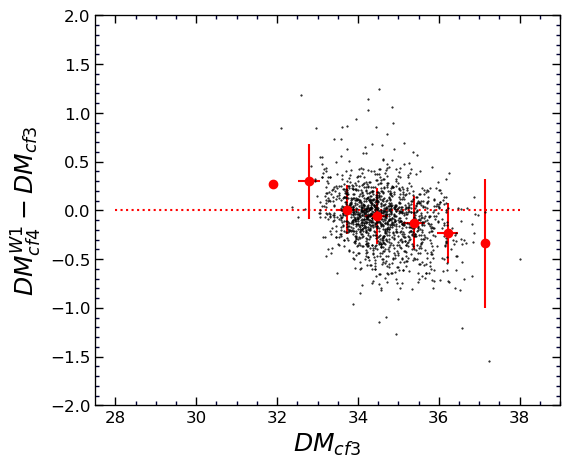

In [34]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = 5.*(np.log10(Vmod) - Y)+25.

XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:      
        ix, = np.where(ID==id)
        ax.errorbar(DM_cf3[i], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(DM_cf3[i])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(29,38,1):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)               
            

ax.set_ylabel(r'$DM^{W1}_{cf4}-DM_{cf3}$', fontsize=18)                                                 
set_axes(ax, [27.5,39],[-2,2], fontsize=12)
ax.plot([28,38],[0,0], 'r:')
ax.set_xlabel('$DM_{cf3}$', fontsize=18) 


3629.0 0.0003980126203373402
5073.0 -0.04554102579201924
6832.5 -0.08283980327508189
8958.5 -0.09243735824121657
10673.0 -0.1152727291027702
12676.0 -0.10811266387044682
14995.5 -0.003922117844304296
17262.5 -0.25581388638737934
-0.07530829388319844


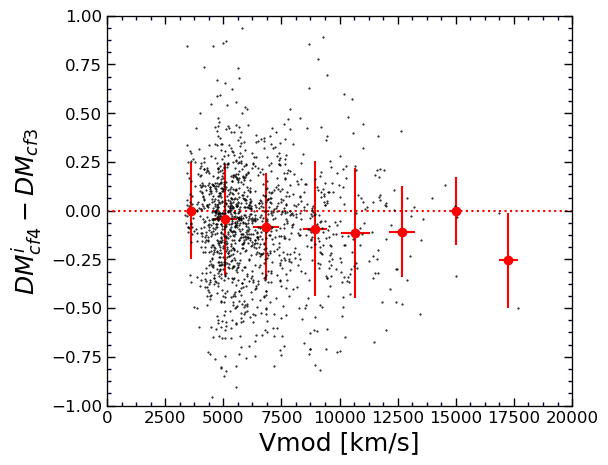

In [35]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:
        ix, = np.where(ID==id)
        ax.errorbar(V[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(V[ix][0])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)      
        print np.median(xp), np.median(yp)
            

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

# set_axes(ax, [27.5,39],[-1,1], fontsize=12)
# ax.plot([28,38],[0,0], 'r:')
# ax.set_xlabel('$DM_{cf3}$', fontsize=18) 

print np.mean(YY)

3629.0 0.0003980126203373402
5073.0 -0.04554102579201924
6832.5 -0.08283980327508189
8958.5 -0.09243735824121657
10673.0 -0.1152727291027702
12676.0 -0.10811266387044682
14995.5 -0.003922117844304296
17262.5 -0.25581388638737934
-0.07530829388319844


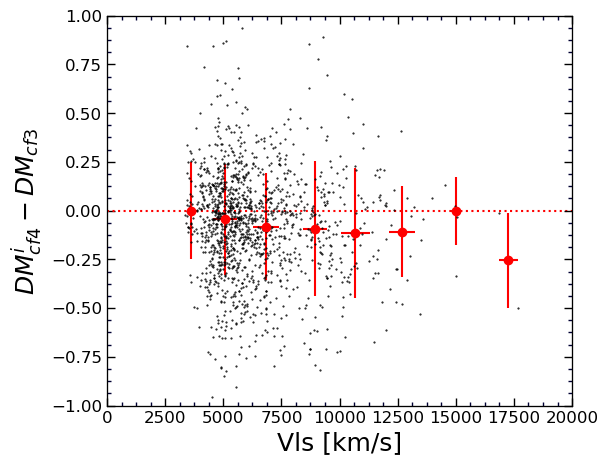

In [36]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:
        ix, = np.where(ID==id)
        ax.errorbar(V[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(V[ix][0])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)      
        print np.median(xp), np.median(yp)
            

ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

# set_axes(ax, [27.5,39],[-1,1], fontsize=12)
# ax.plot([28,38],[0,0], 'r:')
# ax.set_xlabel('$DM_{cf3}$', fontsize=18) 

print np.mean(YY)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


4562 73.3
5415 73.4
6559 73.5
7481 71.8
8486 71.3
9498 73.8
10508 68.8
11484 73.0
12419 68.1
13370 77.4
14389 69.2
15227 68.2
16612 75.1
17606 65.6
73.81362810824976 70.2542554881205
[-1.95126515e-06  1.87594161e+00]
1.868136552416611
4566


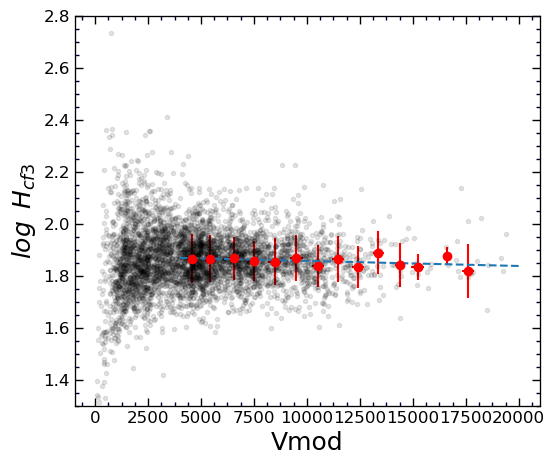

In [37]:
# pgc_edd = table['pgc']
# logWimx   = table['logWimx']
# logWimx_e = table['logWimx_e']
# inc   = table['inc']
# Vmod   = table['Vmod']

# pgc_cf3 = cf3['PGC']
# DM_cf3  = cf3['DM']
# eDM_cf3

Vmod_cf3 = []
logH_cf3 = []
eeDM_cf3 = []

for i, id in enumerate(pgc_cf3):
    
    if id in pgc_edd:      
        ix, = np.where(pgc_edd==id)
        logD_3 = (DM_cf3[i]-25)/5.
        logH_3 = np.log10(Vmod_edd[ix][0]) - logD_3
        Vmod_cf3.append(Vmod_edd[ix][0])
        logH_cf3.append(logH_3)
        eeDM_cf3.append(eDM_cf3[i])

Vmod_cf3 = np.asarray(Vmod_cf3)
logH_cf3 = np.asarray(logH_cf3)
eeDM_cf3  = np.asarray(eeDM_cf3)

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3
Y = logH_cf3
Ye = eeDM_cf3

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vmod', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1/Ye[X>4000])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print len(Y)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


4574 73.5
5401 73.7
6541 73.0
7476 72.5
8493 73.3
9472 75.7
10497 74.7
11480 75.6
12426 76.1
13448 76.2
14432 75.4
15455 77.5
16458 76.0
17520 72.5
73.26122174854719 76.20013688855133
[1.55287223e-06 1.85866267e+00]
1.8648741569469809
8190


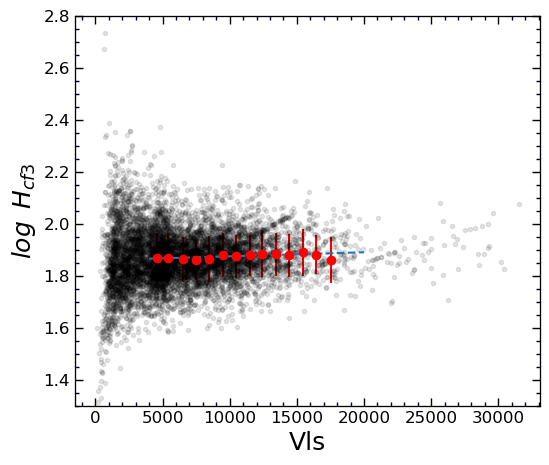

In [38]:
logD_3 = (DM_cf3-25)/5.
logH_3 = np.log10(VVmod_cf3) - logD_3

Vmod_cf3 = VVmod_cf3
logH_cf3 = logH_3
eeDM_cf3 = eDM_cf3

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[(I_cf3=='I') | (H_cf3=='H') | (F_cf3=='F')]
Y = logH_cf3[(I_cf3=='I') | (H_cf3=='H')| (F_cf3=='F')]
Ye = eeDM_cf3[(I_cf3=='I') | (H_cf3=='H')| (F_cf3=='F')]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000 :
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1/Ye[X>4000])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print len(Y)

5 90.7
6 nan
7 nan
8 72.5
9 71.7
10 72.7
11 nan
12 74.0


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


(5, 15)

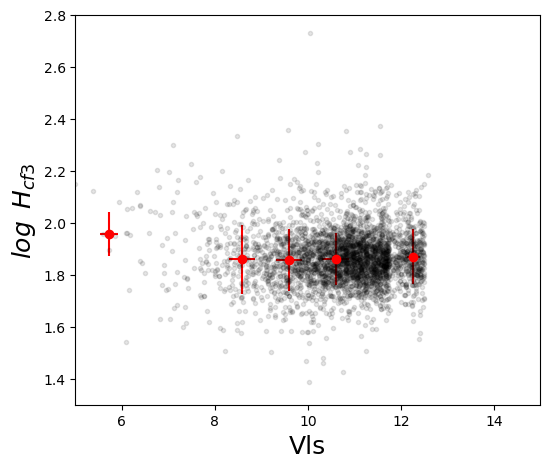

In [39]:
logD_3 = (DM_cf3-25)/5.
logH_3 = np.log10(VVmod_cf3) - logD_3

Vmod_cf3 = Ks_cf3
logH_cf3 = logH_3
eeDM_cf3 = eDM_cf3

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[(I_cf3=='I') | (H_cf3=='H') ]
Y = logH_cf3[(I_cf3=='I') | (H_cf3=='H')]
Ye = eeDM_cf3[(I_cf3=='I') | (H_cf3=='H')]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(5,15,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 :
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

ax.set_ylim(1.3,2.8)
ax.set_xlim(5,15)


0.03999999999999915 1.023292992280766
0.22499999999999964 1.0232929922807494
0.41000000000000014 1.0
0.6099999999999994 1.0
0.8000000000000007 1.0
0.9799999999999986 0.9772372209558151
1.1500000000000004 0.9772372209558111


(<matplotlib.axes._subplots.AxesSubplot at 0x7f36004c3c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35ff729f50>)

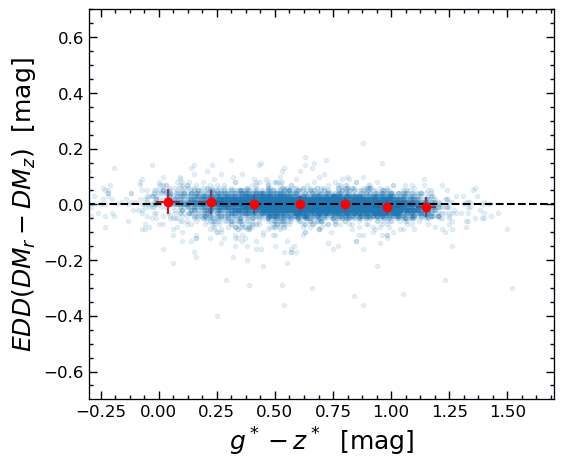

In [40]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-zzz[indx] # logWimx[indx] #
Y = DMr[indx]-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-z^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_z)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

0.03999999999999915 0.9772372209557991
0.22499999999999964 0.9772372209558151
0.41000000000000014 0.9772372209558151
0.6099999999999994 1.0
0.8000000000000007 1.0
0.9799999999999986 1.0232929922807494
1.1500000000000004 1.0232929922807494


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3600a39a10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3600a170d0>)

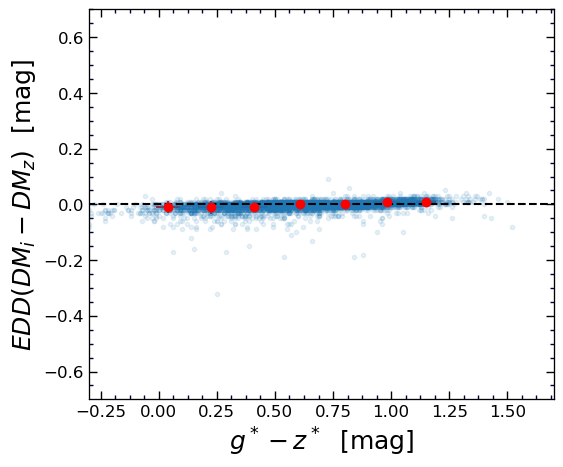

In [41]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-zzz[indx] # logWimx[indx] #
Y = DMi[indx]-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-z^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

0.07000000000000028 1.1748975549395304
0.23000000000000043 1.0964781961432009
0.41999999999999993 0.9549925860214291
0.6099999999999994 0.9120108393559115
0.7999999999999989 1.0
0.9500000000000002 1.0964781961431829
1.1400000000000006 1.7378008287493691


(<matplotlib.axes._subplots.AxesSubplot at 0x7f36016d9650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35ff0f6450>)

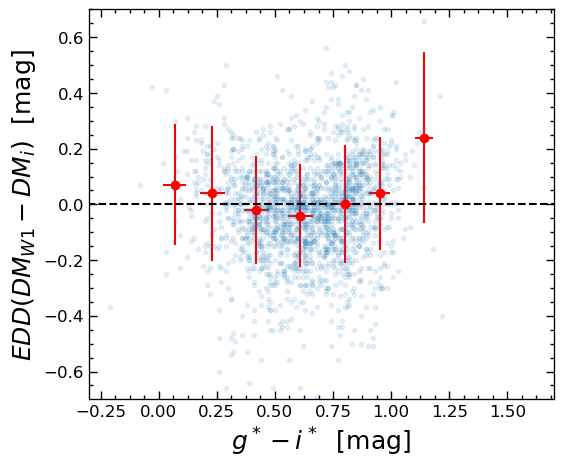

In [42]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) &
                 (Wqlt>3) & (w11>0) )

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-iii[indx] # logWimx[indx] #
Y = DM_w1[indx]-DMi[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-i^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

In [43]:
np.median(DMi[indx]-DMz[indx])

0.0

[ 2.29563101e-07 -1.13007296e-03]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fe0e6f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fe152990>)

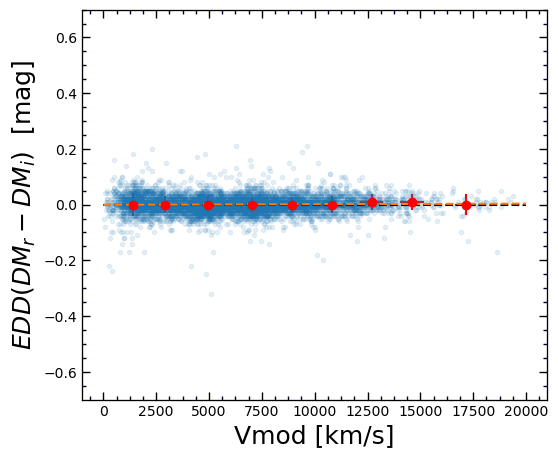

In [44]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & 
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vmod[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


v = np.linspace(0,20000,2000)
c = np.polyfit(X,Y, 1)
ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

[ 3.09604283e-07 -4.84497196e-03]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fdde6650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fddc4fd0>)

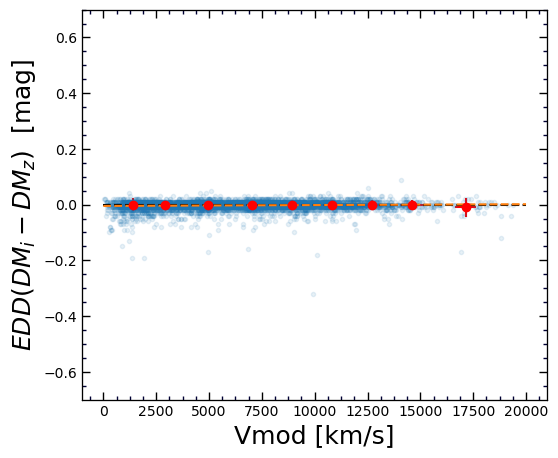

In [45]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & 
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vmod[indx] #
Y = (DMi[indx])-DMz[indx]
Ye = np.sqrt(dDMi**2+dDMz**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


v = np.linspace(0,20000,2000)
c = np.polyfit(X,Y, 1)
ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

-0.010000000000005116
0.009467456535490486


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fdb35c90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fdba6fd0>)

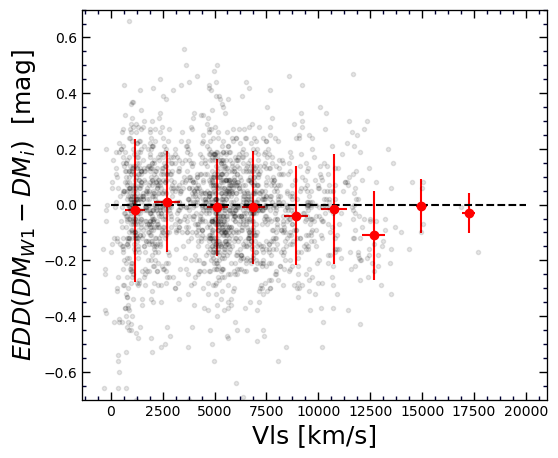

In [46]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
Vls   = table['Vls']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vls[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


# v = np.linspace(0,20000,2000)
# c = np.polyfit(X,Y, 1)
# ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)

# c = np.polyfit(X,Y, 0, w=1./Ye)
# ax.plot(v, v*0+c[0], '--')


ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print  np.sum(Y/Ye)/np.sum(1./Ye)

set_axes(ax, fontsize=10)

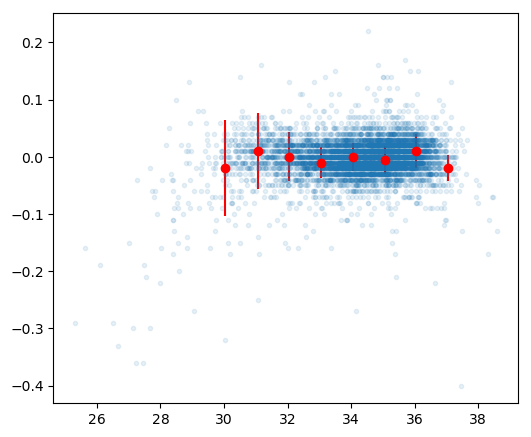

In [47]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

indx, = np.where((Sqlt>3) & (keep==1) & (zzz>0))
                # & (Wqlt>3) & (w11>0)) 

# X =  logWimx[indx] #
X =  DMr[indx]
Y = (DMr[indx])-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(30,38,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.10:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
        


In [48]:
indx, = np.where((zzz>0) & (Sqlt>3) & (Wqlt>3) & (Vmod<20000))
Y = DM_w1[indx]-DMz[indx]
Ye = np.sqrt(dDM_w1[indx]**2+dDMz[indx]**2)
print np.sum(Y/Ye)/np.sum(1./Ye)
np.median(Y), np.mean(Y), np.std(Y)

0.005847674850790074


(-0.019999999999999574, -0.03976949485041698, 0.22604234247102686)

-0.010000000000005116
[ 0.06745019 -0.14030492]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fd758b50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fd74de10>)

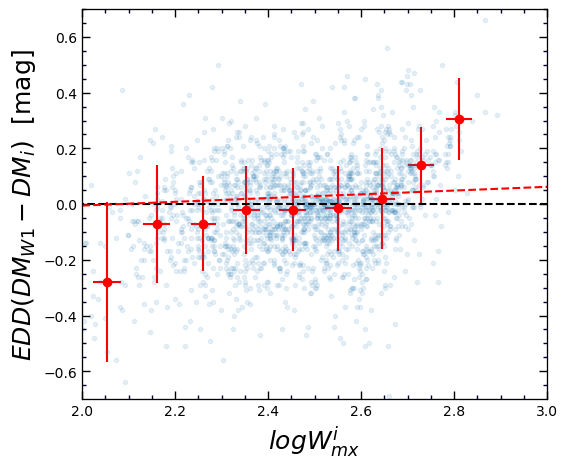

In [49]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.10:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X[(X>2.2)&(X<2.7)],Y[(X>2.2)&(X<2.7)], 1, w=1./Ye[(X>2.2)&(X<2.7)])
ax.plot(v,c[0]*v+c[1], 'r--')
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print c
set_axes(ax, fontsize=10)

In [50]:
np.median(Y)

-0.010000000000005116

[ 0.01645965 -0.58254049]
-0.010000000000005116


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fd5108d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fd5443d0>)

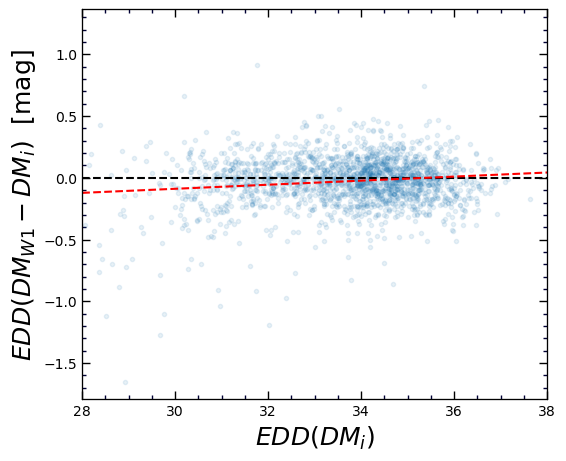

In [51]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMi[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.10:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{i})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)

[0.00010034 0.00101911]
0.0
[0.00010034 0.00101911]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fd33bfd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fd375fd0>)

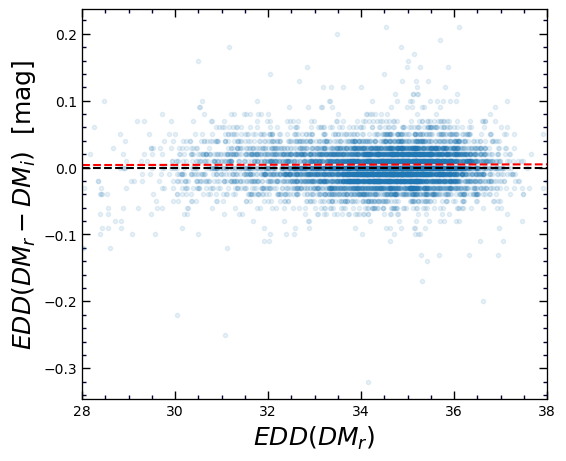

In [52]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMr[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1/Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{r})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print m
set_axes(ax, fontsize=10)

[-0.00026813  0.00865165]
0.0
[-0.00026813  0.00865165]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f35fd0ef4d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35fd0cbf10>)

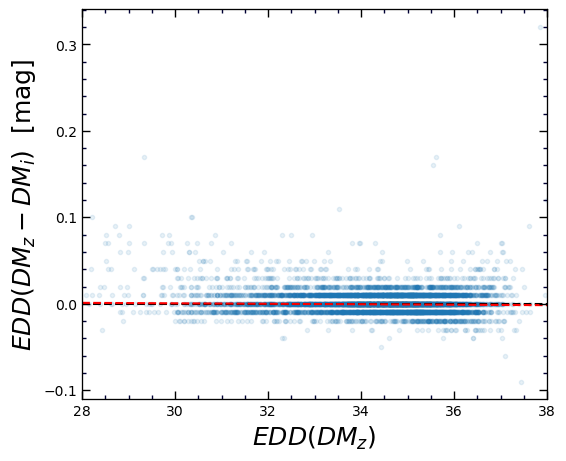

In [53]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMz[indx] #
Y = (DMz[indx])-DMi[indx]
Ye = np.sqrt(dDMz**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1/Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{z})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{z}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print m
set_axes(ax, fontsize=10)

[-0.0572721   0.27712629 -0.33231133]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3602c58d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f36018a0e10>)

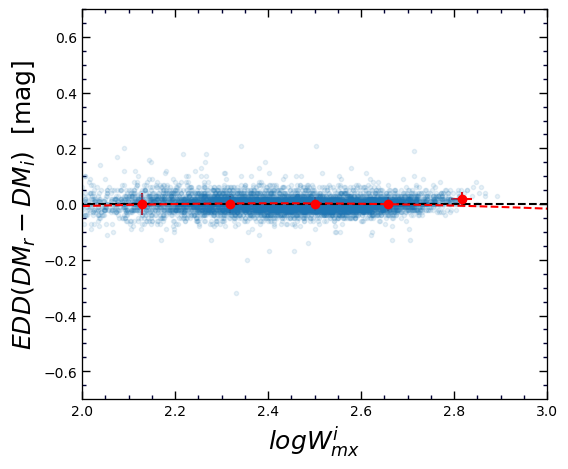

In [54]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X,Y, 2)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'r--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

[-0.05817067  0.29840256 -0.38159305]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3600a7d590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f36018a00d0>)

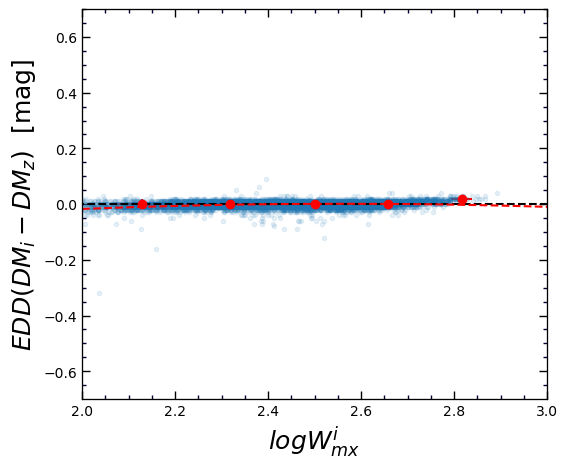

In [55]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DMi[indx])-DMz[indx]
Ye = np.sqrt(dDMi**2+dDMz**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X,Y, 2)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'r--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)